This is the first try on implementing a LSTM on this project.

In [519]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Semilla fija para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [520]:

# Cargar archivo unificado
df = pd.read_csv("oferta_academica_unificada.csv")

# Eliminar filas sin datos clave
df = df.dropna(subset=['Materia', 'Total_Cupos', 'semestre_numerico'])

# Codificar materia
le = LabelEncoder()
df['materia_codificada'] = le.fit_transform(df['Materia'])

# Guardar mapeo seguro
diccionario_materias = dict(zip(df['materia_codificada'], df['Materia']))

# Crear columna de cupos efectivamente usados
df['Cupos_Usados'] = df['Total_Cupos'] - df['Residuos_Cupos'].fillna(0)

# Variables a escalar (sin codificar materia)
escalar = ['Total_Secciones', 'semestre_numerico', 'Cupos_Usados', 'Residuos_Cupos']
scaler = MinMaxScaler()
df[escalar] = scaler.fit_transform(df[escalar])

# Features y target
features = ['materia_codificada', 'Total_Secciones', 'semestre_numerico', 'Residuos_Cupos', 'Cupos_Usados']
target = 'Cupos_Usados'


In [521]:
def crear_secuencias(data, pasos):
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i+pasos, :-1])
        y.append(data[i+pasos, -1])
    return np.array(X), np.array(y)

pasos = 1
X_total, y_total = [], []

for materia_id in df['materia_codificada'].unique():
    grupo = df[df['materia_codificada'] == materia_id].sort_values('semestre_numerico')
    valores = grupo[features + [target]].values
    if len(valores) > pasos:
        X_seq, y_seq = crear_secuencias(valores, pasos)
        X_total.append(X_seq)
        y_total.append(y_seq)

X = np.vstack(X_total)
y = np.concatenate(y_total)

print("✅ Secuencias creadas:", X.shape)


✅ Secuencias creadas: (237, 1, 5)


In [522]:
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(pasos, len(features))))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=100, verbose=1)

Epoch 1/100
8/8 [==============================] - 2s 4ms/step - loss: 0.1121
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0507
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0459
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0388
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0345
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0312
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0288
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0251
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0201
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0173
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

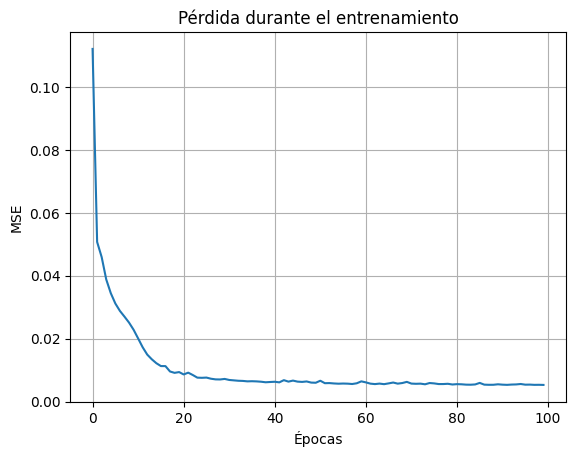

In [523]:
plt.plot(history.history['loss'])
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


In [524]:
predicciones = {}

for materia_id in df['materia_codificada'].unique():
    materia_df = df[df['materia_codificada'] == materia_id].sort_values('semestre_numerico')
    valores = materia_df[features + [target]].values

    if len(valores) >= pasos:
        secuencia = valores[-pasos:, :-1].reshape(1, pasos, len(features))
        y_pred = model.predict(secuencia)[0][0]

    
        ultima_fila_real = materia_df[escalar].values[-1].copy()
        ultima_fila_real[-1] = y_pred
        
        cupo_estimado = max(0, scaler.inverse_transform([ultima_fila_real])[0][-1])

        nombre_materia = diccionario_materias.get(materia_id, f"ID {materia_id}")
        predicciones[nombre_materia] = round(cupo_estimado)


1/1 [==============================] - 0s 13ms/step


In [525]:
df_pred = pd.DataFrame(list(predicciones.items()), columns=["Materia", "Cupos_Estimados"])
df_pred.to_excel("predicciones_cupos_proximo_semestre.xlsx", index=False)
print("✅ Archivo guardado: predicciones_cupos_proximo_semestre.xlsx")


✅ Archivo guardado: predicciones_cupos_proximo_semestre.xlsx


In [526]:
# Mostrar todas las predicciones
for materia, cupo in predicciones.items():
    print(f"{materia}: {cupo} cupos estimados")

ADMINISTRACION DE BASES DE DATOS: 71 cupos estimados
ADMINISTRACION DE REDES: 25 cupos estimados
ADMINISTRACION DE SERVIDORES: 43 cupos estimados
ALGORITMIA: 37 cupos estimados
ALMACENES DE DATOS (DATA WAREHOUSE): 48 cupos estimados
BASES DE DATOS: 43 cupos estimados
CLASIFICACION INTELIGENTE DE DATOS: 58 cupos estimados
CONTROL DE PROYECTOS: 61 cupos estimados
ESTADISTICA Y PROCESOS ESTOCASTICOS: 81 cupos estimados
ESTRUCTURAS DE DATOS I: 7 cupos estimados
ESTRUCTURAS DE DATOS II: 14 cupos estimados
HIPERMEDIA: 41 cupos estimados
INGENIERIA DE SOFTWARE I: 11 cupos estimados
INGENIERIA DE SOFTWARE II: 50 cupos estimados
MATEMATICA DISCRETA: 3 cupos estimados
METODOS MATEMATICOS I: 114 cupos estimados
METODOS MATEMATICOS II: 97 cupos estimados
MINERIA DE DATOS: 64 cupos estimados
PROGRAMACION: 106 cupos estimados
PROGRAMACION PARA INTERNET: 154 cupos estimados
SEGURIDAD DE LA INFORMACION: 80 cupos estimados
SEMINARIO DE SOLUCION DE PROBLEMAS DE BASES DE DATOS: 71 cupos estimados
SEMINAR